## Micrograd Lecture
#### https://youtu.be/VMj-3S1tku0?si=L9uoak1hkI_eeD3T

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def func1(x):
    return 2*x**3 + 5*x + 3

In [3]:
x = np.arange(-5, 5, 0.25)
y = func1(x)

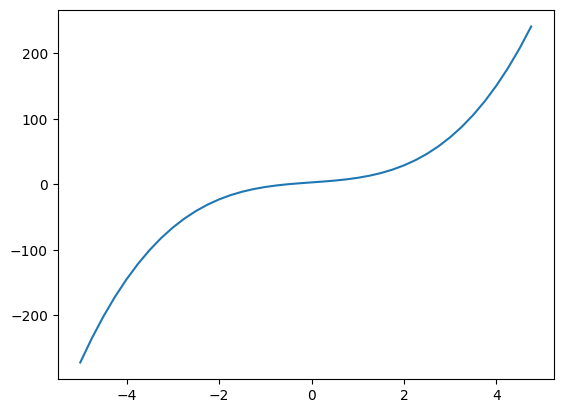

In [4]:
plt.plot(x,y)

#### Finding the slope at -3 aka the derivative of this function at -3

$$
f'(x) = \frac{f(x+h)-f(x)}{h}
$$

In [5]:
h = 0.0000001
(func1(-3+h)-func1(-3))/h # +ve

58.99999820258017

In [6]:
(func1(0+h)-func1(0))/h # +ve

5.00000000069889

#### equation with multiple variables

In [7]:
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print("d1:", d1)
print("d2:", d2)
print("slope:", (d2-d1)/h)

d1: 4.0
d2: 3.9999997
slope: -2.9999999995311555


#### Creating the Value class

In [8]:
class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __add__(self, other):
        
        if not isinstance(other, Value):
            other = Value(other)

        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    # def __radd__(self, other):
    #     return self + other

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __rsub__(self, other):
        return self - other

    def __mul__(self, other):

        if not isinstance(other, Value):
            other = Value(other)
            
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward

        return out

    def __rmul__(self, other):
        return self * other

    def __pow__(self, other):
        
        assert isinstance(other, (int, float)), "Only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f"**{other}")

        def _backward():
            self.grad += other * (self.data ** (other-1)) * out.grad
        out._backward = _backward

        return out

    def __truediv__(self, other):
        return self.data * other**-1

    def exp(self):
        out = Value(math.exp(self.data), (self,), "exp")

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), "tanh")

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    def backward(self):
        # Topological Sorting algo
        topo = []
        visited = set()
        def topo_sort(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    topo_sort(child)
                topo.append(v)

        topo_sort(self)
        
        # Calling backwards on all nodes in topological order
        self.grad = 1.0
        for v in reversed(topo):
            v._backward()
        
    def __repr__(self):
        return f"Value(data={self.data}, label={self.label})"

In [9]:
# Addition
a = Value(2.0, label="a")
print(a + 1)
print(1 + a)
# Multiplication
print(a * 2)
print(2 * a)
# Subtraction
print(a - 1)
print(1 - a)
# Division
print(a / 1)
# Power
print(a ** 2)

Value(data=3.0, label=)
Value(data=3.0, label=)
Value(data=4.0, label=)
Value(data=4.0, label=)
Value(data=1.0, label=)
Value(data=1.0, label=)
2.0
Value(data=4.0, label=)


In [10]:
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
e = a*b
e.label = "e"
d = e + c
d.label = "d"
f = Value(-2.0, label="f")
L = d*f; L.label="L"

In [11]:
# Check why dL/db = 0??? It shouldnt be
def comp():
    
    h = 0.0001
    
    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a*b
    d = e + c
    f = Value(-2.0, label="f")
    L = d*f
    L1 = L.data

    a = Value(2.0, label="a")
    # a.data += h
    b = Value(-3.0, label="b")
    # b.data += h
    c = Value(10.0, label="c")
    # c.data += h
    e = a*b
    e.data += h
    d = e + c
    f = Value(-2.0, label="f")
    L = d*f
    L2 = L.data

    print((L2 - L1)/h)

comp()

-1.9999999999953388


In [12]:
# Got from manual calculation
L.grad = 1.0
f.grad = 4.0
d.grad = -2.0
e.grad = -2.0
c.grad = -2.0
a.grad = 6.0
b.grad = -4.0

In [13]:
# Visualization function
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

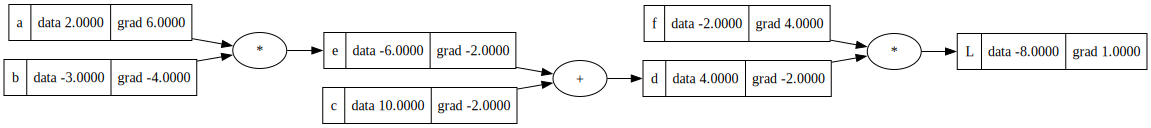

In [14]:
draw_dot(L)

- $d * f = L$
- $\frac{dL}{df} = \frac{d(d*f)}{df} = d = 4.0$
- $\frac{dL}{dd} = \frac{d(d*f)}{dd} = f = -2.0$
<br>
- c + e = d
- dL/dc = (dL/dd) * (dd/dc) = (d(d*f)/dd) * (d(c+e)/dc) = f * 1 = f = -2.0 //chain rule
- dL/de = (dL/dd) * (dd/de) = (d(d*f)/dd) * (d(c+e)/de) = f * 1 = f = -2.0
<br />

- a * b = e
- dL/da = (dL/dd) * (dd/de) * (de/da) = (d(d*f)/dd) * (d(c+e)/de) * (d(a*b)/da) = f * 1 * b = -2 * -3 = 6.0
- dL/db = f * 1 * a = -2 * 2 = -4.0

#### Doing backprop on a simple MLP

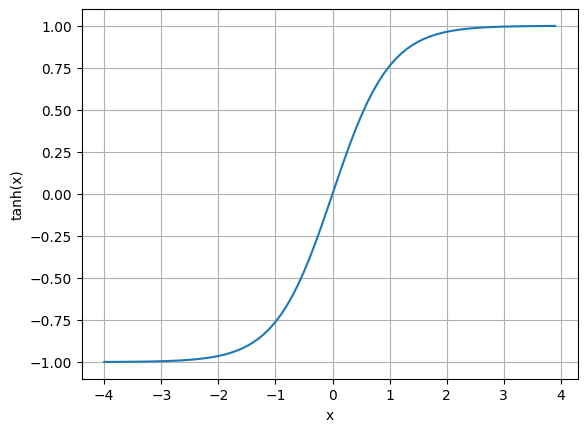

In [15]:
# Plotting tanh
def plot_tanh():
    x = np.arange(-4,4,0.1)
    y = np.tanh(x)
    plt.plot(x,y)
    plt.grid()
    plt.xlabel("x")
    plt.ylabel("tanh(x)");
    
plot_tanh()

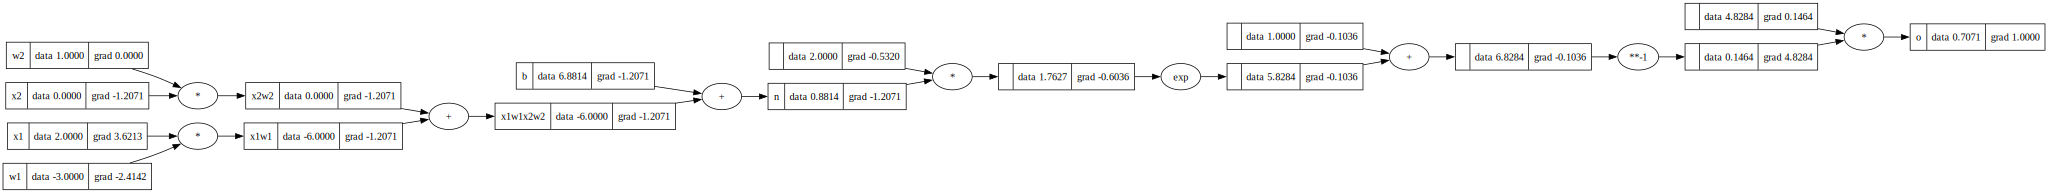

In [16]:
# Inputs x1 and x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# Weights w1 and w1
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# Bias term
b = Value(6.8813735870195432, label="b")
# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = "x1w1"
x2w2 = x2 * w2; x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1x2w2"
n = x1w1x2w2 + b; n.label = "n"
e = (2*n).exp()
o = (e - 1)/(e + 1); o.label = "o"
# o = n.tanh(); o.label = "o"
o.backward()
draw_dot(o)

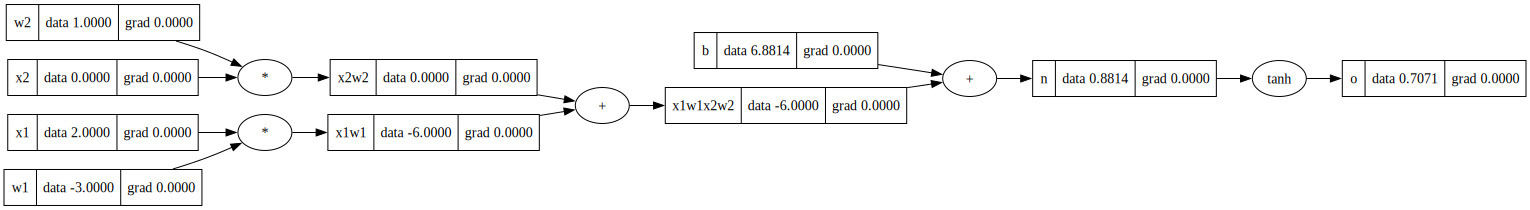

In [17]:
# Inputs x1 and x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# Weights w1 and w1
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# Bias term
b = Value(6.8813735870195432, label="b")
# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = "x1w1"
x2w2 = x2 * w2; x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1x2w2"
n = x1w1x2w2 + b; n.label = "n"
o = n.tanh(); o.label = "o"
draw_dot(o)

$$
\frac{do}{dn} = 1 - (tanh(n))^2 = 1 - o^2
$$

do/do = 1

do/dn = 1 - (0.7071)**2 = 0.5

x1w1x2w2 + b = n

do/db = do/dn * dn/db = 0.500 * 1 = 0.500

do/dx1w1x2w2 = do/dn * dn/dx1w1x2w2 = 0.500 * 1 = 0.500

x1w1 + x2w2 = x1w1x2w2

do/dx1w1 = do/dn * dn/dx1w1x2w2 * dx1w1x2w2/dx1w1 = 0.5 * 1 * 1 = 0.5

do/dx2w2 = 0.5

x1 * w1 = x1w1

do/dw1 = do/dn * dn/dx1w1x2w2 * dx1w1x2w2/dx1w1 * dx1w1/dw1 = 0.5 * 1 * 1 * 2 = 1

do/dx1 = do/dn * dn/dx1w1x2w2 * dx1w1x2w2/dx1w1 * dx1w1/dx1 = 0.5 * 1 * 1 * -3 = -1.5

x2 * w2 = x2w2

do/dw2 = do/dn * dn/dx1w1x2w2 * dx1w1x2w2/dx2w2 * dx2w2/dw2 = 0.5 * 1 * 1 * 0 = 0

do/dx2 = do/dn * dn/dx1w1x2w2 * dx1w1x2w2/dx2w2 * dx2w2/dx2 = 0.5 * 1 * 1 * 1 = 0.5

In [18]:
o.grad = 1.0
n.grad = 0.5
b.grad = 0.5
x1w1x2w2.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5
x1.grad = -1.5
x2.grad = 0.5
w1.grad = 1
w2.grad = 0

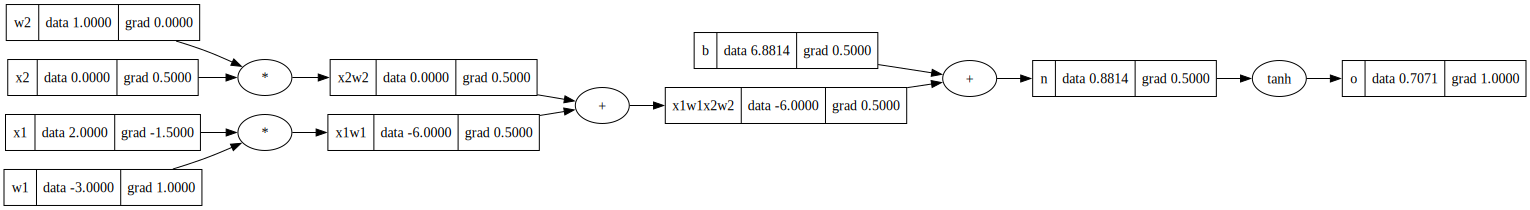

In [19]:
draw_dot(o)

In [20]:
# Automatic gradient calculation called one after another
o.grad = 1.0
o._backward()
n._backward()
x1w1x2w2._backward()
b._backward()
x1w1._backward()
x2w2._backward()
x1._backward()
x2._backward()
w1._backward()
w2._backward()

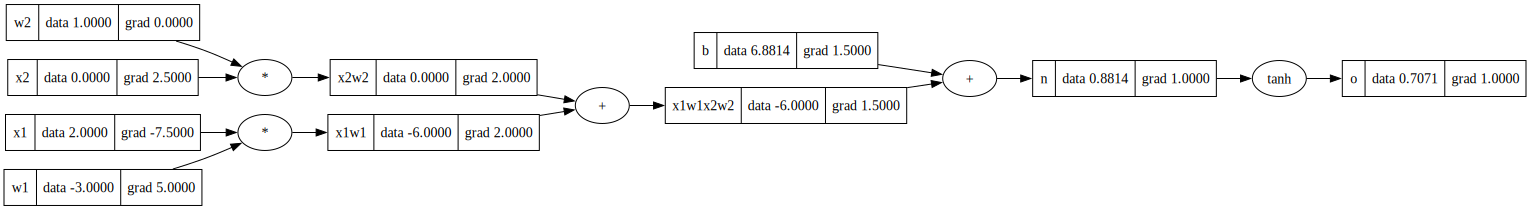

In [21]:
draw_dot(o)

In [22]:
# Topological sorting: Algo to visit the entire tree (like forward passs) and store the visited nodes in the order in which they were first visited
# https://youtu.be/5lZ0iJMrUMk?si=Lc-Zqmzwg91QxNlp
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=6.881373587019543, label=b),
 Value(data=1.0, label=w2),
 Value(data=0.0, label=x2),
 Value(data=0.0, label=x2w2),
 Value(data=2.0, label=x1),
 Value(data=-3.0, label=w1),
 Value(data=-6.0, label=x1w1),
 Value(data=-6.0, label=x1w1x2w2),
 Value(data=0.8813735870195432, label=n),
 Value(data=0.7071067811865476, label=o)]

In [23]:
# o.grad = 1.0
for v in reversed(topo):
    v._backward()

In [24]:
o.backward()

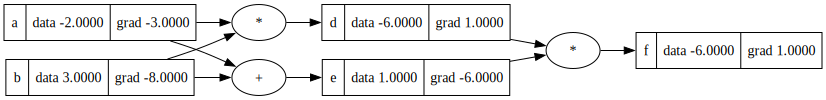

In [25]:
# Gradients accumulate bug
a = Value(-2.0, label="a")
b = Value(3.0, label="b")
d = a * b; d.label="d"
e = a + b; e.label="e"
f = d * e; f.label = "f"
f.backward()
draw_dot(f)